## MIE1516 Final Project: Buildling Typology Classification from Streetview Images Using a CNN


This project is an extension of my current thesis with the Civil Engineering department, and would be used in the wider efforts to quantify the material flows and stocks within the City of Toronto. This work, if successful, would help triangulate building typology (e.g. what is it used for) against several other data sources and would enable far more accurate analysis of material use in the city.

The ultimate goal of this project is to accurately predict building use (e.g. residential, commercial, industrial) given a photograph of the building's exterior. Building use has an impact on construction type, and so accurately predicting building use is a key component of this effort.

The training data for this project comes from two sources:
- A labelled set of building typologies exists in the publically available [Building Permits](https://www.toronto.ca/city-government/data-research-maps/open-data/open-data-catalogue/#c9117f72-4eaf-5e45-f3a6-b8b465074217) from the City of Toronto
- Images for each location were downloaded in a 600x400 resolution using the google streetview API. This script can be found in the Image_Retriever notebook.
Because I gathered the data for this project, a major concern was around the noise present in the dataset. While most of the images scraped from google streetview effectively capture the building they are indexed to, some consist of images from inside the building or are otherwise nonesensible. 

The aim of this project is to investigate how classifer accuracy can be increased, as ideally this work could end up being used as part of a larger effort.

# Sections
### 0 Notebook Initialization

0.1 Imports

0.2 Assistant Function Defintion

0.3 Global Initializations

### 1 Preprocessing Data Scraped from Google Streetview

1.1: Sorting the data into folders as required by the flow_from_directory process

1.2: Formatting Images for Use in the CNN

### 2: CNN Efficacy as a result of the Dataset

2.1: Training a CNN on the imbalanced and unaugmented dataset

2.2: Data Augmentation

2.3: Class Weighting (as an alternative to SMOTE)

### 3: Binary Class Prediction between Commercial and House

3.1: Same CNN architecture for binary class prediction

3.2: Binary Class Prediction with Dedicated Binary Class Architecture

3.2.5: Dedicated Binary Architecture with no data augmentation

3.3: Tuning Learning Rate and Optimizer

3.4: Binary Classifier with Batch Normalization

### 4: Interpretability

4.1: Saliency Maps

### 5: Conclusion

# 0: Notebook Initialization

### 0.1: Imports

In [3]:
import os
import shutil
import numpy as np
#import cPickle
import _pickle as cPickle #uncomment this on the VM for it to work
import pandas as pd 
from numpy import argmax
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.metrics import confusion_matrix


import tensorflow as tf
import tensorflow.python.keras
from tensorflow.python.keras.models import Sequential 
from tensorflow.python.keras.models import model_from_json
from tensorflow.python.keras.layers import Dense, Activation, Dropout, Flatten, BatchNormalization
from tensorflow.python.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.python.keras import backend as K
from tensorflow.python.keras import regularizers
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

### 0.2: Assistant Function Definitions

In [6]:
#taken from assignment 3
def print_confusion_matrix(confusion_matrix, class_names, 
                           figsize = (10,7), fontsize=14):

    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [7]:
#taken from auraham's post from https://stackoverflow.com/questions/43469281/how-to-predict-input-image-using-trained-model-in-keras
from tensorflow.python.keras.preprocessing import image

def load_image(img_path, show=False):

    img = image.load_img(img_path, target_size=(64, 64))
    img_tensor = image.img_to_array(img)                    # (height, width, channels)
    img_tensor = np.expand_dims(img_tensor, axis=0)         # (1, height, width, channels), add a dimension because the model expects this shape: (batch_size, height, width, channels)
    img_tensor /= 255.                                      # imshow expects values in the range [0, 1]

    if show:
        plt.imshow(img_tensor[0])                           
        plt.axis('off')
        plt.show()

    return img_tensor

In [8]:
#had to write custom confusion matrix code to avoid an issue with binary classification and
#the way I've been doing it in the past (the output of binary is a val between 0 and 1 that indicates
#the degree of probability, which goops up the regular confusion matrix code)
def binaryCompMatrix(inputModel, path):
    #path = '64_Scaled_Limited/Testing/'
    folders = ['Commercial', 'House']
    
    outputArray = np.array([[0, 0], [0, 0]])
    x_counter = 0
    for i in folders:

        for j in os.listdir(path+i):
            test_image = load_image(path + i + '/'+j)
            pred = inputModel.predict(test_image)
            if(pred>0.5):
                outputArray[x_counter][1] += 1
            else:
                outputArray[x_counter][0] += 1

        x_counter += 1
        
    return outputArray

### 0.3 Global Initializations

In [9]:
nb_train_samples = 7734
nb_validation_samples = 1897
epochs = 10
batch_size = 16
class_labels = ['Apartment', 'Commercial', 'House', 'Industrial','Institutional','Office']

# 1: Preprocessing Data scraped from Google Streetview
### 1.1: Sorting the data into folders as required by the flow_from_directory process
The data output from my Image_Retriever notebook is in one large folder. I am looking to use a similar structure to the one for in [this](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html) tutorial, as it demonstrates a number of data augmentation approaches for working in low data environements, which will be important later. This section crops and scales my data in preparation for the CNN, and then organizes it into the necessary file heirachy.

In [22]:
#contains the labels
labeledDF = pd.read_excel('Classifier_Building_Data.xlsx', sheet_name='Sheet2')

In [41]:
os.mkdir("Data/")
for i in labeledDF['New Typology'].unique():
    os.mkdir("Data/" + str(i))

In [52]:
#There are 21 folders containing scraped streetview images, this rebundles them by class
for i in range(0,21):
    teststr = str(i)
    counter = 0
    path = 'Project/'+teststr
    for filename in os.listdir(path):
        address = filename[:filename.find(',')]
        typology = labeledDF.loc[labeledDF['Address'] == address, 'New Typology'].iloc[0]
        src = path+"/"+filename
        dst = 'Data/'+typology
        exists = os.path.isfile(dst +"/"+filename)
        if exists:
            counter += 1
            print(counter)
        else:
            shutil.move(src,dst)

### 1.2: Formatting Images for Use in the CNN
Images were pulled from google streetview in a 600x400 pixel format. In order to meet this resolution requirement, the google streetview API cut pixels from all margins of image in order to end with a 600x400 image of the center of the image. This focuses the images on the structure of interest, as being taken from google streetview these images often include a large amount of lawn / sky.

To go from the 600x400 to the 64x64 or 32x32 format for classification, my first step is to cut a square from the image (256x256). This Square will then be compressed down to the 64x64 or 32x32 format for classification

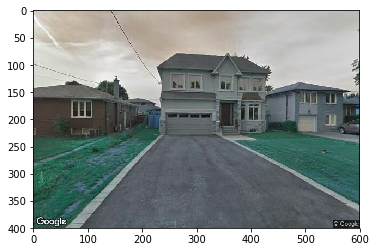

In [5]:
#Sample starting image
import cv2
image = cv2.imread("test.jpg")

plt.imshow(image)
plt.show()

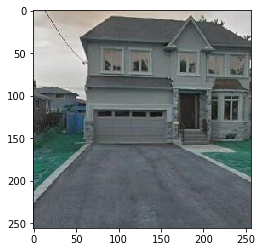

In [16]:
#cropping to 256 by 256 square
height = int(image.shape[0])
width = int(image.shape[1])

if ((height >= 256) and (width >= 256)):
    y_start = (height - 256) / 2
    x_start = (width - 256) / 2
    crop_img = image[y_start:(y_start+256), x_start:(x_start+256)]

plt.imshow(crop_img)
plt.show()

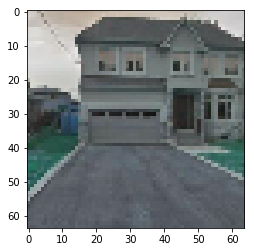

In [19]:
#lowering resolution for ease of CNN training
new_res = 64

scaled_img = cv2.resize(crop_img, (new_res, new_res))

plt.imshow(scaled_img)
plt.show()

In [20]:
cv2.imwrite("test_cropped.jpg", scaled_img)

True

In [37]:
import cv2

class_list = labeledDF['New Typology'].unique()

#creating output folders
os.mkdir('32_Scaled')
for i in class_list:
    os.mkdir('32_Scaled/' + i)

counter = 0
for i in class_list:
    path = 'Data/' + i
    for filename in os.listdir(path):
        out_path = '32_Scaled/' + i +'/' + filename
        
        image_read = cv2.imread(path+"/"+filename)
        
        #cropping to 256 by 256 square
        height = int(image_read.shape[0])
        width = int(image_read.shape[1])

        if ((height >= 256) and (width >= 256)):
            y_start = (height - 256) / 2
            x_start = (width - 256) / 2
            crop_img = image_read[y_start:(y_start+256), x_start:(x_start+256)]
        
            scaled_img = cv2.resize(crop_img, (32,32))
            
            #plt.imshow(scaled_img)
            #plt.show()
            
            cv2.imwrite(out_path, scaled_img)
        else:
            counter += 1
            print(counter)

# 2: CNN Efficacy as a result of the Dataset

### 2.1: Training a CNN on the imbalanced and unaugmented dataset
The classes are very imbalanced as a result of data availability (as often is the case with real-world datasets). Nonetheless, I am curious to see what level of performance is possible using the non-augmented training set and the full set of 6 classes. 

In [39]:
train_datagen = ImageDataGenerator()
    #rescale=1. / 255,
    #shear_range=0.2,
    #zoom_range=0.2,
    #horizontal_flip=True)

test_datagen = ImageDataGenerator()

training_set = train_datagen.flow_from_directory('64_Scaled/Training', target_size=(64,64), batch_size=32)

test_set = test_datagen.flow_from_directory('64_Scaled/Testing', target_size=(64,64), batch_size=32)


Found 7734 images belonging to 6 classes.
Found 1897 images belonging to 6 classes.


In [41]:
#This architecture is a modified version of that used in assignment 3. I was forced to remove some of the layers
#to deal with a tensorflow error that resulted from different shape geometry between my images and those in the
#CIFAR dataset. This was not a major issue, as my hypothesis is that the class imbalance will have a major impact
#on the performance to start with, and this is purely to evaluate the extent to which this is true
with tensorflow.device('/gpu:0'):
    model = Sequential()

    weight_decay = 1e-4
    num_classes = 6
    model.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay), input_shape=(64, 64, 3)))
    model.add(Activation('elu'))
    model.add(BatchNormalization())
    model.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(Activation('elu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.2))

    """
    model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(Activation('elu'))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(Activation('elu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.3))

    model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(Activation('elu'))
    model.add(BatchNormalization())
    model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(Activation('elu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.4))
    """

    model.add(Flatten())
    model.add(Dense(12))
    model.add(Activation('relu'))
    model.add(Dense(num_classes, activation='softmax'))

    model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 64, 64, 32)        896       
_________________________________________________________________
activation_23 (Activation)   (None, 64, 64, 32)        0         
_________________________________________________________________
batch_normalization_v1_18 (B (None, 64, 64, 32)        128       
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 64, 64, 32)        9248      
_________________________________________________________________
activation_24 (Activation)   (None, 64, 64, 32)        0         
_________________________________________________________________
batch_normalization_v1_19 (B (None, 64, 64, 32)        128       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 32, 32, 32)        0         
__________

In [42]:
opt = tensorflow.keras.optimizers.Adam(lr=0.0011)
# Let's train the model using RMSprop
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [43]:
model.fit_generator(
        training_set,
        steps_per_epoch=2000 // batch_size,
        epochs=20,
        validation_data=test_set,
        validation_steps=800 // batch_size)

Epoch 1/20
242/242 [==============================] - 9s 39ms/step - loss: 3.7503 - acc: 0.7653 - val_loss: 3.9824 - val_acc: 0.7501
Epoch 2/20
242/242 [==============================] - 9s 37ms/step - loss: 3.7484 - acc: 0.7674 - val_loss: 3.9821 - val_acc: 0.7501
Epoch 3/20
242/242 [==============================] - 9s 37ms/step - loss: 3.7519 - acc: 0.7674 - val_loss: 3.9818 - val_acc: 0.7501
Epoch 4/20
242/242 [==============================] - 9s 37ms/step - loss: 3.7507 - acc: 0.7674 - val_loss: 4.0245 - val_acc: 0.7501
Epoch 5/20
242/242 [==============================] - 9s 37ms/step - loss: 3.7504 - acc: 0.7674 - val_loss: 4.0242 - val_acc: 0.7501
Epoch 6/20
242/242 [==============================] - 9s 37ms/step - loss: 3.7483 - acc: 0.7674 - val_loss: 4.0240 - val_acc: 0.7501
Epoch 7/20
242/242 [==============================] - 9s 37ms/step - loss: 3.7490 - acc: 0.7674 - val_loss: 4.0237 - val_acc: 0.7501
Epoch 8/20
242/242 [==============================] - 9s 37ms/step - 

The classifer never improves its acc and val_acc (after the first step, and even there only by 0.21%)! This is the result of the unbalanced classes (similar issues found [here](https://datascience.stackexchange.com/questions/30930/accuracy-and-loss-dont-change-in-cnn-is-it-over-fitting)), with the confusion matrix below supporting this. The prevalence of houses in the dataset results in a local min where the classifier only predicts houses.


In [44]:
Y_pred = model.predict_generator(test_set, 1897 // batch_size + 1)
y_pred = np.argmax(Y_pred, axis=1)

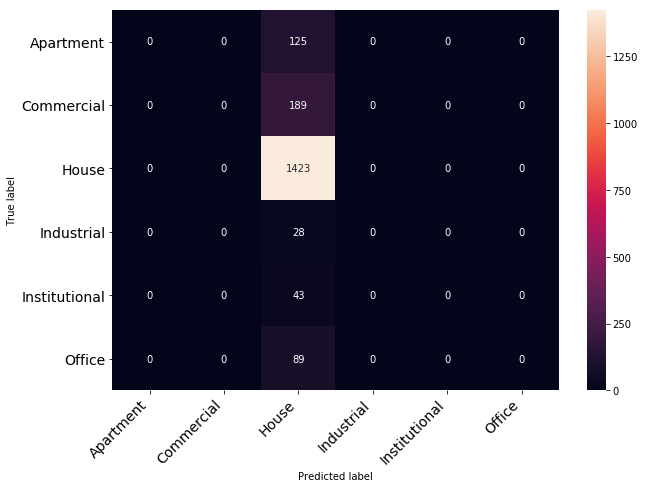

In [48]:
print_confusion_matrix(confusion_matrix(test_set.classes, y_pred), class_labels)

As expected, the imbalance is the result of viciously unbalanced classes (leading to a viciously unbalanced classifier). The next steps are clearly to address this imbalance before we dive into the CNN architecture itself.

### 2.2: Data Augmentation
Here I'm generating some data synthetic data using the elements of our sample set. While this does not correct the imbalance exactly (the ratio between class examples will still be roughly the same), this will simply add MORE examples to the less frequent classes. I am curious to see if we will end up predicting more than a single class

In [49]:
train_datagen = ImageDataGenerator(rescale=1. / 255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)

test_datagen = ImageDataGenerator()

training_set = train_datagen.flow_from_directory('64_Scaled/Training', target_size=(64,64), batch_size=32)

test_set = test_datagen.flow_from_directory('64_Scaled/Testing', target_size=(64,64), batch_size=32)


Found 7734 images belonging to 6 classes.
Found 1897 images belonging to 6 classes.


In [50]:
with tensorflow.device('/gpu:0'):
    model = Sequential()

    weight_decay = 1e-4
    num_classes = 6
    model.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay), input_shape=(64, 64, 3)))
    model.add(Activation('elu'))
    model.add(BatchNormalization())
    model.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(Activation('elu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.2))

    """
    model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(Activation('elu'))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(Activation('elu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.3))

    model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(Activation('elu'))
    model.add(BatchNormalization())
    model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(Activation('elu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.4))
    """

    model.add(Flatten())
    model.add(Dense(12))
    model.add(Activation('relu'))
    model.add(Dense(num_classes, activation='softmax'))

    model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 64, 64, 32)        896       
_________________________________________________________________
activation_26 (Activation)   (None, 64, 64, 32)        0         
_________________________________________________________________
batch_normalization_v1_20 (B (None, 64, 64, 32)        128       
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 64, 64, 32)        9248      
_________________________________________________________________
activation_27 (Activation)   (None, 64, 64, 32)        0         
_________________________________________________________________
batch_normalization_v1_21 (B (None, 64, 64, 32)        128       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 32, 32, 32)        0         
__________

In [51]:
opt = tensorflow.keras.optimizers.Adam(lr=0.0011)
# Let's train the model using RMSprop
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [52]:
model.fit_generator(
        training_set,
        steps_per_epoch=2000 // batch_size,
        epochs=20,
        validation_data=test_set,
        validation_steps=800 // batch_size)

Epoch 1/20
242/242 [==============================] - 20s 83ms/step - loss: 1.2946 - acc: 0.7075 - val_loss: 1.6016 - val_acc: 0.7501
Epoch 2/20
242/242 [==============================] - 19s 79ms/step - loss: 1.0678 - acc: 0.7675 - val_loss: 2.7598 - val_acc: 0.7501
Epoch 3/20
242/242 [==============================] - 19s 79ms/step - loss: 0.9058 - acc: 0.7674 - val_loss: 1.5760 - val_acc: 0.7501
Epoch 4/20
242/242 [==============================] - 19s 79ms/step - loss: 0.7670 - acc: 0.7674 - val_loss: 1.8480 - val_acc: 0.7501
Epoch 5/20
242/242 [==============================] - 19s 78ms/step - loss: 0.7273 - acc: 0.7674 - val_loss: 3.0383 - val_acc: 0.7501
Epoch 6/20
242/242 [==============================] - 19s 79ms/step - loss: 0.7124 - acc: 0.7731 - val_loss: 3.4973 - val_acc: 0.7617
Epoch 7/20
242/242 [==============================] - 19s 78ms/step - loss: 0.7006 - acc: 0.7872 - val_loss: 1.7811 - val_acc: 0.7259
Epoch 8/20
242/242 [==============================] - 19s 80ms

We managed to break out of the local min and find some higher val_acc (we can see that the val_acc appears to be oscillating between ~0.76 and ~0.25 - ~0.35). This behaviour is extremely interesting, but I believe that this is caused by the classifier alternatively predicting house and commercial with high frequency. As the final epoch resulted in a low val_acc, we can see from the confusion matrix below that this is indeed the case, with the classifier predicting commercial at an extremely high rate.

In [53]:
Y_pred = model.predict_generator(test_set, 1897 // batch_size + 1)
y_pred = np.argmax(Y_pred, axis=1)

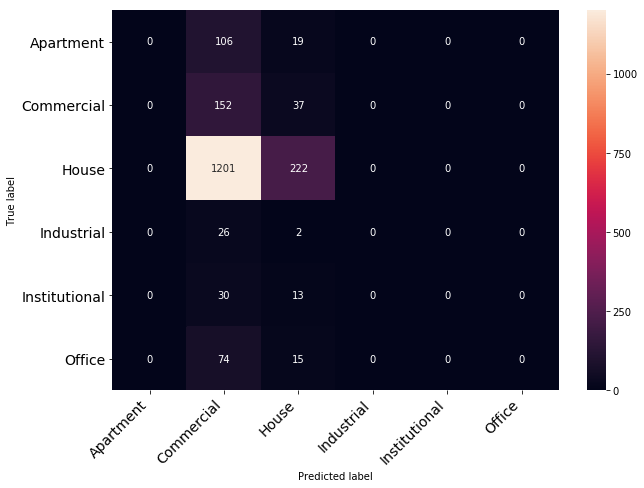

In [54]:
print_confusion_matrix(confusion_matrix(test_set.classes, y_pred), class_labels)

### 2.3: Class Weighting (as an alternative to SMOTE)
After searching the Keras documentation I was dissappointed to find that they don't offer any SMOTE functionality. My instinct is that in order to deal with this class imbalance we should generate some synthetic data. I could do this using external image manipulation, but first I will attempt to use the built-in Keras tools to solve this problem.

My first class weighting is designed to (hopefully) coax the classifier into predicting apartments, and to sort out the strange oscillations seen previously between commercial and house.

In [60]:
class_weights = {0: 10, 1: 2, 2:1, 3:1, 4:1, 5:1}

In [57]:
train_datagen = ImageDataGenerator(rescale=1. / 255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)

test_datagen = ImageDataGenerator()

training_set = train_datagen.flow_from_directory('64_Scaled/Training', target_size=(64,64), batch_size=32)

test_set = test_datagen.flow_from_directory('64_Scaled/Testing', target_size=(64,64), batch_size=32)


Found 7734 images belonging to 6 classes.
Found 1897 images belonging to 6 classes.


In [58]:
with tensorflow.device('/gpu:0'):
    model = Sequential()

    weight_decay = 1e-4
    num_classes = 6
    model.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay), input_shape=(64, 64, 3)))
    model.add(Activation('elu'))
    model.add(BatchNormalization())
    model.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(Activation('elu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.2))

    """
    model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(Activation('elu'))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(Activation('elu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.3))

    model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(Activation('elu'))
    model.add(BatchNormalization())
    model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(Activation('elu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.4))
    """

    model.add(Flatten())
    model.add(Dense(12))
    model.add(Activation('relu'))
    model.add(Dense(num_classes, activation='softmax'))

    model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_22 (Conv2D)           (None, 64, 64, 32)        896       
_________________________________________________________________
activation_29 (Activation)   (None, 64, 64, 32)        0         
_________________________________________________________________
batch_normalization_v1_22 (B (None, 64, 64, 32)        128       
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 64, 64, 32)        9248      
_________________________________________________________________
activation_30 (Activation)   (None, 64, 64, 32)        0         
_________________________________________________________________
batch_normalization_v1_23 (B (None, 64, 64, 32)        128       
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 32, 32, 32)        0         
__________

In [59]:
opt = tensorflow.keras.optimizers.Adam(lr=0.0011)
# Let's train the model using RMSprop
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [61]:
model.fit_generator(
        training_set,
        steps_per_epoch=2000 // batch_size,
        epochs=20,
        validation_data=test_set,
        validation_steps=800 // batch_size,
class_weight = class_weights)

Epoch 1/20
242/242 [==============================] - 20s 83ms/step - loss: 1.6997 - acc: 0.6409 - val_loss: 1.4725 - val_acc: 0.7501
Epoch 2/20
242/242 [==============================] - 19s 79ms/step - loss: 1.3048 - acc: 0.7613 - val_loss: 1.5356 - val_acc: 0.4881
Epoch 3/20
242/242 [==============================] - 19s 80ms/step - loss: 1.1676 - acc: 0.7298 - val_loss: 1.7677 - val_acc: 0.5946
Epoch 4/20
242/242 [==============================] - 19s 80ms/step - loss: 1.1249 - acc: 0.7371 - val_loss: 2.0704 - val_acc: 0.7027
Epoch 5/20
242/242 [==============================] - 19s 79ms/step - loss: 1.0770 - acc: 0.7462 - val_loss: 2.1182 - val_acc: 0.6431
Epoch 6/20
242/242 [==============================] - 19s 80ms/step - loss: 1.0448 - acc: 0.7446 - val_loss: 2.9800 - val_acc: 0.7296
Epoch 7/20
242/242 [==============================] - 19s 79ms/step - loss: 1.0265 - acc: 0.7356 - val_loss: 3.3161 - val_acc: 0.7501
Epoch 8/20
242/242 [==============================] - 19s 80ms

In [62]:
Y_pred = model.predict_generator(test_set, 1897 // batch_size + 1)
y_pred = np.argmax(Y_pred, axis=1)

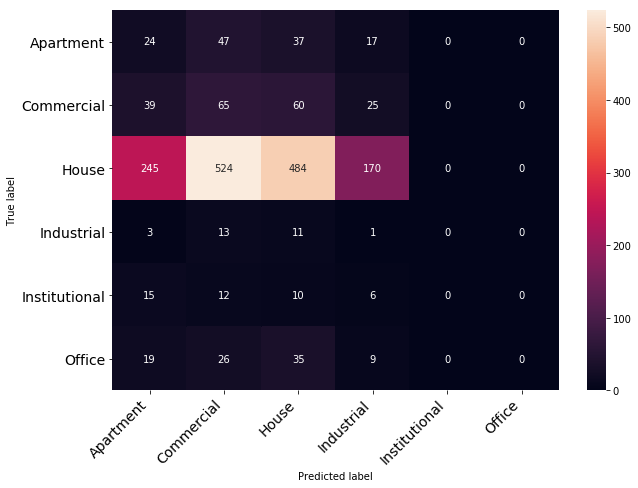

In [63]:
print_confusion_matrix(confusion_matrix(test_set.classes, y_pred), class_labels)

Well we got it predicting 4 classes at least. What I find particularly concerning is the massive delta between the acc and val_acc values, implying that a substantial amount of overfitting is occuring here. While this could be addressed by modifying the CNN architecture (increasing dropout percentage for example), I am concerned that the issue is not driven by the classifier, but rather by the dataset itself. 

For the remainder of this project I will be looking at a simple binary classification problem between the two largest classes, house and commercial. I am interested in doing this to assess whether it is possible to get meaningful performance over this dataset (scraped google streetview images scaled to 64x64) at all.

# 3: Binary Class Prediction between Commercial and House
In addition to removing the other classes from the training and testing set, I've also directly balanced the size of the training sets between the commercial and the house classes (by deleting elements from the house training set at random until the same number of elements exist in both sets). While the same effect could be obtained by balancing the elements in each batch ([as described here](https://imbalanced-learn.readthedocs.io/en/latest/auto_examples/applications/porto_seguro_keras_under_sampling.html)), I opted to go for the data deletion as I was curious to investigate the process [from this tutorial](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html) where data augmentation was used to attain meaningful performance with only 1,000 examples for each class.

### 3.1: Same CNN architecture for binary class prediction

In [4]:
train_datagen = ImageDataGenerator(rescale=1. / 255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)

test_datagen = ImageDataGenerator()

training_set = train_datagen.flow_from_directory('64_Scaled_Limited/Training', target_size=(64,64), batch_size=32)

test_set = test_datagen.flow_from_directory('64_Scaled_Limited/Testing', target_size=(64,64), batch_size=32)

class_labels = ['Commercial','House']


Found 1458 images belonging to 2 classes.
Found 1612 images belonging to 2 classes.


In [53]:
with tensorflow.device('/gpu:0'):
    model = Sequential()

    weight_decay = 1e-4
    num_classes = 6
    model.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay), input_shape=(64, 64, 3)))
    model.add(Activation('elu'))
    model.add(BatchNormalization())
    model.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(Activation('elu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.2))

    """
    model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(Activation('elu'))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(Activation('elu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.3))

    model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(Activation('elu'))
    model.add(BatchNormalization())
    model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(Activation('elu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.4))
    """

    model.add(Flatten())
    model.add(Dense(12))
    model.add(Activation('relu'))
    model.add(Dense(2, activation='softmax'))

    model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, 64, 64, 32)        896       
_________________________________________________________________
activation_22 (Activation)   (None, 64, 64, 32)        0         
_________________________________________________________________
batch_normalization_v1_4 (Ba (None, 64, 64, 32)        128       
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 64, 64, 32)        9248      
_________________________________________________________________
activation_23 (Activation)   (None, 64, 64, 32)        0         
_________________________________________________________________
batch_normalization_v1_5 (Ba (None, 64, 64, 32)        128       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 32, 32, 32)        0         
__________

In [54]:
opt = tensorflow.keras.optimizers.Adam(lr=0.0011)
# Let's train the model using RMSprop
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [55]:
model.fit_generator(
        training_set,
        steps_per_epoch=2000 // batch_size,
        epochs=20,
        validation_data=test_set,
        validation_steps=400 // batch_size)

Epoch 1/20
46/46 [==============================] - 5s 105ms/step - loss: 0.7349 - acc: 0.5919 - val_loss: 0.5226 - val_acc: 0.8821
Epoch 2/20
46/46 [==============================] - 4s 91ms/step - loss: 0.5993 - acc: 0.7414 - val_loss: 10.5339 - val_acc: 0.1917
Epoch 3/20
46/46 [==============================] - 4s 90ms/step - loss: 0.5299 - acc: 0.7647 - val_loss: 1.8869 - val_acc: 0.8828
Epoch 4/20
46/46 [==============================] - 4s 88ms/step - loss: 0.4973 - acc: 0.7826 - val_loss: 1.8791 - val_acc: 0.8828
Epoch 5/20
46/46 [==============================] - 4s 88ms/step - loss: 0.4476 - acc: 0.8073 - val_loss: 1.8309 - val_acc: 0.8859
Epoch 6/20
46/46 [==============================] - 4s 89ms/step - loss: 0.4350 - acc: 0.8100 - val_loss: 1.8869 - val_acc: 0.8828
Epoch 7/20
46/46 [==============================] - 4s 88ms/step - loss: 0.4220 - acc: 0.8244 - val_loss: 1.6559 - val_acc: 0.8914
Epoch 8/20
46/46 [==============================] - 4s 89ms/step - loss: 0.4011 -

In [56]:
Y_pred = model.predict_generator(test_set, 1612 // batch_size + 1)
y_pred = np.argmax(Y_pred, axis=1)

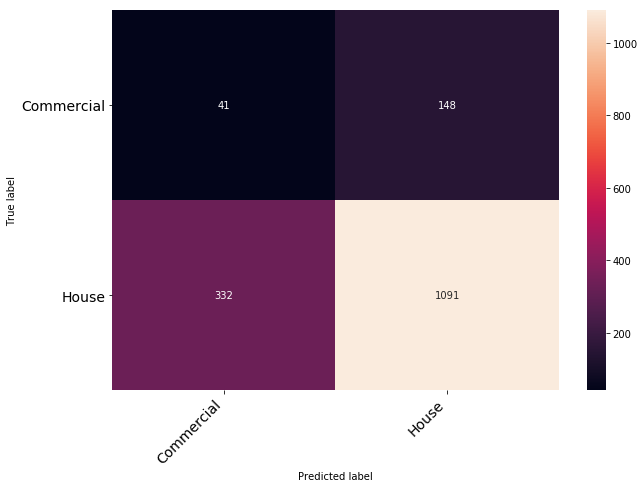

In [57]:
print_confusion_matrix(confusion_matrix(test_set.classes, y_pred), class_labels)

It's still predicting house very heavily! This really isn't great performance, so I'm going to move to a dedicated binary class architecture to see if we can do better.

### 3.2: Binary Class Prediction with Dedicated Binary Class Architecture

In [38]:
#Change from previous generators is that these are now loading in binary mode
train_datagen = ImageDataGenerator(rescale=1. / 255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)

test_datagen = ImageDataGenerator()

training_set = train_datagen.flow_from_directory('64_Scaled_Limited/Training', target_size=(64,64), batch_size=32, class_mode='binary')

test_set = test_datagen.flow_from_directory('64_Scaled_Limited/Testing', target_size=(64,64), batch_size=32, class_mode='binary')

class_labels = ['Commercial','House']

Found 1458 images belonging to 2 classes.
Found 1612 images belonging to 2 classes.


In [39]:
#this archictecture taken from https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html
#but slightly modified to accept our different sized images
with tensorflow.device('/gpu:0'):
    
    model = Sequential()
    
    model.add(Conv2D(32, (3, 3), input_shape=(64,64,3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(32, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Flatten())
    model.add(Dense(64))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))

    model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 62, 62, 32)        896       
_________________________________________________________________
activation_21 (Activation)   (None, 62, 62, 32)        0         
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 29, 29, 32)        9248      
_________________________________________________________________
activation_22 (Activation)   (None, 29, 29, 32)        0         
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 12, 12, 64)        18496     
__________

In [40]:
#Note that this is a different optimizer than we have been using previously! 
model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [41]:
model.fit_generator(
        training_set,
        steps_per_epoch=1458 // batch_size,
        epochs=20,
        validation_data=test_set,
        validation_steps=1612 // batch_size)

Epoch 1/20
46/46 [==============================] - 4s 93ms/step - loss: 0.6855 - acc: 0.5480 - val_loss: 9.7194 - val_acc: 0.3579
Epoch 2/20
46/46 [==============================] - 4s 87ms/step - loss: 0.6349 - acc: 0.6509 - val_loss: 10.0629 - val_acc: 0.3617
Epoch 3/20
46/46 [==============================] - 4s 85ms/step - loss: 0.5923 - acc: 0.6982 - val_loss: 6.8183 - val_acc: 0.5614
Epoch 4/20
46/46 [==============================] - 4s 86ms/step - loss: 0.5551 - acc: 0.7469 - val_loss: 5.0741 - val_acc: 0.6743
Epoch 5/20
46/46 [==============================] - 4s 86ms/step - loss: 0.5215 - acc: 0.7627 - val_loss: 1.5590 - val_acc: 0.8983
Epoch 6/20
46/46 [==============================] - 4s 87ms/step - loss: 0.4969 - acc: 0.7867 - val_loss: 3.1941 - val_acc: 0.7940
Epoch 7/20
46/46 [==============================] - 4s 85ms/step - loss: 0.4882 - acc: 0.7894 - val_loss: 3.7509 - val_acc: 0.7605
Epoch 8/20
46/46 [==============================] - 4s 86ms/step - loss: 0.4701 - 

Quite similar performance overall (as defined by accuracy), although looking at the confusion matrix paints a different story. The classifer has started to more accuratley predict commercial structures, and avoids issues with 

In [45]:
confArray = binaryCompMatrix(model, '64_Scaled_Limited/Testing/')

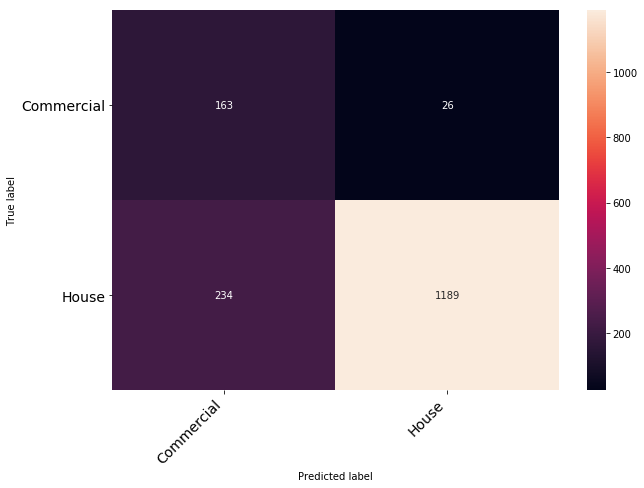

In [46]:
print_confusion_matrix(confArray, class_labels)

Not too shabby! Let's see if we can get better though, particularly with the precision in house prediction.

### 3.2.5: Dedicated Binary Architecture with no data augmentation
This is mostly just out of curiosity to see how performance changes.

In [100]:
#Change from previous generators is that these are now loading in binary mode
train_datagen = ImageDataGenerator() #rescale=1. / 255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)

test_datagen = ImageDataGenerator()

training_set = train_datagen.flow_from_directory('64_Scaled_Limited/Training', target_size=(64,64), batch_size=32, class_mode='binary')

test_set = test_datagen.flow_from_directory('64_Scaled_Limited/Testing', target_size=(64,64), batch_size=32, class_mode='binary')

class_labels = ['Commercial','House']

Found 1458 images belonging to 2 classes.
Found 1612 images belonging to 2 classes.


In [101]:
#this archictecture taken from https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html
#but slightly modified to accept our different sized images
with tensorflow.device('/gpu:0'):
    
    model = Sequential()
    
    model.add(Conv2D(32, (3, 3), input_shape=(64,64,3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(32, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Flatten())
    model.add(Dense(64))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))

    model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 62, 62, 32)        896       
_________________________________________________________________
activation_5 (Activation)    (None, 62, 62, 32)        0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 29, 29, 32)        9248      
_________________________________________________________________
activation_6 (Activation)    (None, 29, 29, 32)        0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 12, 12, 64)        18496     
__________

In [102]:
#Note that this is a different optimizer than we have been using previously! 
model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [103]:
model.fit_generator(
        training_set,
        steps_per_epoch=1458 // batch_size,
        epochs=20,
        validation_data=test_set,
        validation_steps=1612 // batch_size)

Epoch 1/20
46/46 [==============================] - 2s 53ms/step - loss: 7.9084 - acc: 0.5021 - val_loss: 1.8951 - val_acc: 0.8828
Epoch 2/20
46/46 [==============================] - 2s 42ms/step - loss: 7.9362 - acc: 0.5027 - val_loss: 1.8951 - val_acc: 0.8828
Epoch 3/20
46/46 [==============================] - 2s 42ms/step - loss: 7.9948 - acc: 0.4966 - val_loss: 1.8951 - val_acc: 0.8828
Epoch 4/20
46/46 [==============================] - 2s 42ms/step - loss: 7.9794 - acc: 0.5000 - val_loss: 1.8951 - val_acc: 0.8828
Epoch 5/20
46/46 [==============================] - 2s 43ms/step - loss: 8.0925 - acc: 0.4925 - val_loss: 1.8951 - val_acc: 0.8828
Epoch 6/20
46/46 [==============================] - 2s 42ms/step - loss: 7.9827 - acc: 0.4986 - val_loss: 1.8951 - val_acc: 0.8828
Epoch 7/20
46/46 [==============================] - 2s 43ms/step - loss: 8.0299 - acc: 0.4952 - val_loss: 1.8951 - val_acc: 0.8828
Epoch 8/20
46/46 [==============================] - 2s 43ms/step - loss: 7.9740 - a

I'd recognize that val_acc anywhere, it's just guess house everytime. 

### 3.3: Tuning Learning Rate and Optimizer
Now that our performance is starting to improve at least, I thought that it would be interesting to see how adjusting the optimizer and the learning rate would impact performance. My preferred optimizer is the Adam optimizer (after how well it performed on assignment 3), and I tried several learning rates to find an optimal

In [10]:
train_datagen = ImageDataGenerator(rescale=1. / 255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)

test_datagen = ImageDataGenerator()

training_set = train_datagen.flow_from_directory('64_Scaled_Limited/Training', target_size=(64,64), batch_size=32, class_mode='binary')

test_set = test_datagen.flow_from_directory('64_Scaled_Limited/Testing', target_size=(64,64), batch_size=32, class_mode='binary')

class_labels = ['Commercial','House']


Found 1458 images belonging to 2 classes.
Found 1612 images belonging to 2 classes.


In [11]:
with tensorflow.device('/gpu:0'):
    
    model2 = Sequential()
    
    model2.add(Conv2D(32, (3, 3), input_shape=(64,64,3)))
    model2.add(Activation('relu'))
    model2.add(MaxPooling2D(pool_size=(2, 2)))

    model2.add(Conv2D(32, (3, 3)))
    model2.add(Activation('relu'))
    model2.add(MaxPooling2D(pool_size=(2, 2)))

    model2.add(Conv2D(64, (3, 3)))
    model2.add(Activation('relu'))
    model2.add(MaxPooling2D(pool_size=(2, 2)))
    
    model2.add(Flatten())
    model2.add(Dense(64))
    model2.add(Activation('relu'))
    model2.add(Dropout(0.5))
    model2.add(Dense(1))
    model2.add(Activation('sigmoid'))

    model2.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 62, 62, 32)        896       
_________________________________________________________________
activation (Activation)      (None, 62, 62, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 29, 29, 32)        9248      
_________________________________________________________________
activation_1 (Activation)    (None, 29, 29, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxP

In [12]:
#Using the Adam optimizer, learning rate tuned to find better performance
opt = tensorflow.keras.optimizers.Adam(lr=0.0005)
# Let's train the model using RMSprop
model2.compile(loss='binary_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [13]:
model2.fit_generator(
        training_set,
        steps_per_epoch=1458 // batch_size,
        epochs=50,
        validation_data=test_set,
        validation_steps=1612 // batch_size)

Instructions for updating:
Use tf.cast instead.
Epoch 1/50
46/46 [==============================] - 5s 111ms/step - loss: 0.6922 - acc: 0.5274 - val_loss: 10.0008 - val_acc: 0.2457
Epoch 2/50
46/46 [==============================] - 4s 83ms/step - loss: 0.6421 - acc: 0.6481 - val_loss: 9.5197 - val_acc: 0.3945
Epoch 3/50
46/46 [==============================] - 4s 85ms/step - loss: 0.5796 - acc: 0.6941 - val_loss: 7.7088 - val_acc: 0.5068
Epoch 4/50
46/46 [==============================] - 4s 86ms/step - loss: 0.5733 - acc: 0.7133 - val_loss: 12.0921 - val_acc: 0.2463
Epoch 5/50
46/46 [==============================] - 4s 86ms/step - loss: 0.5314 - acc: 0.7490 - val_loss: 11.3701 - val_acc: 0.2885
Epoch 6/50
46/46 [==============================] - 4s 85ms/step - loss: 0.5299 - acc: 0.7545 - val_loss: 3.1644 - val_acc: 0.7965
Epoch 7/50
46/46 [==============================] - 4s 86ms/step - loss: 0.5254 - acc: 0.7558 - val_loss: 6.7788 - val_acc: 0.5713
Epoch 8/50
46/46 [=============

Epoch 38/50
46/46 [==============================] - 4s 85ms/step - loss: 0.3254 - acc: 0.8752 - val_loss: 1.8729 - val_acc: 0.8815
Epoch 39/50
46/46 [==============================] - 4s 83ms/step - loss: 0.3042 - acc: 0.8827 - val_loss: 1.2640 - val_acc: 0.9194
Epoch 40/50
46/46 [==============================] - 4s 84ms/step - loss: 0.2860 - acc: 0.8834 - val_loss: 2.0527 - val_acc: 0.8703
Epoch 41/50
46/46 [==============================] - 4s 84ms/step - loss: 0.2856 - acc: 0.8944 - val_loss: 2.1082 - val_acc: 0.8672
Epoch 42/50
46/46 [==============================] - 4s 83ms/step - loss: 0.2847 - acc: 0.8971 - val_loss: 1.3374 - val_acc: 0.9156
Epoch 43/50
46/46 [==============================] - 4s 86ms/step - loss: 0.2936 - acc: 0.8930 - val_loss: 1.4311 - val_acc: 0.9094
Epoch 44/50
46/46 [==============================] - 4s 85ms/step - loss: 0.2646 - acc: 0.9005 - val_loss: 2.1294 - val_acc: 0.8654
Epoch 45/50
46/46 [==============================] - 4s 85ms/step - loss: 0.

In [14]:
confArray3 = binaryCompMatrix(model2, '64_Scaled_Limited/Testing/')

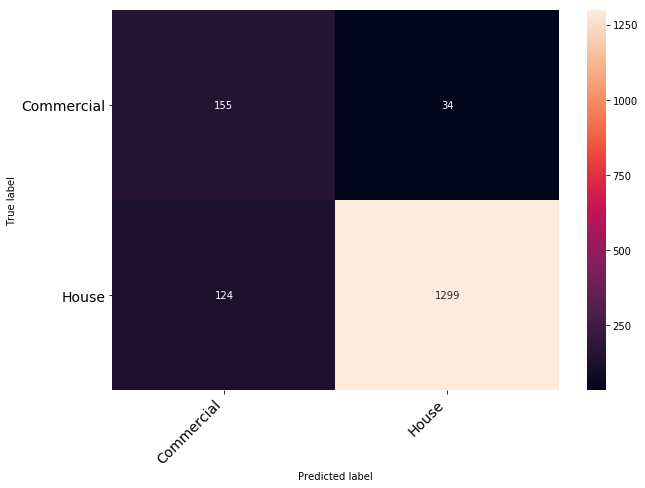

In [15]:
print_confusion_matrix(confArray3, class_labels)

Precision on house has improved, at the cost of a very slight precision hit on commercial. Before moving on to saliency maps I'd like to see what happens if I incorporate a batch normalizer to lower error

### 3.4: Binary Classifier with Batch Normalization

In [49]:
train_datagen = ImageDataGenerator(rescale=1. / 255, shear_range=0.2, zoom_range=0.3, width_shift_range=0.2, height_shift_range=0.2, horizontal_flip=True)

test_datagen = ImageDataGenerator()

training_set = train_datagen.flow_from_directory('64_Scaled_Limited/Training', target_size=(64,64), batch_size=32, class_mode='binary')

test_set = test_datagen.flow_from_directory('64_Scaled_Limited/Testing', target_size=(64,64), batch_size=32, class_mode='binary')

class_labels = ['Commercial','House']


Found 1458 images belonging to 2 classes.
Found 1612 images belonging to 2 classes.


In [54]:
with tensorflow.device('/gpu:0'):
    
    model2 = Sequential()
    
    model2.add(Conv2D(32, (3, 3), input_shape=(64,64,3)))
    model2.add(Activation('relu'))
    model2.add(BatchNormalization())
    model2.add(MaxPooling2D(pool_size=(2, 2)))

    model2.add(Conv2D(32, (3, 3)))
    model2.add(Activation('relu'))
    model2.add(BatchNormalization())
    model2.add(MaxPooling2D(pool_size=(2, 2)))

    model2.add(Conv2D(64, (3, 3)))
    model2.add(Activation('relu'))
    model2.add(BatchNormalization())
    model2.add(MaxPooling2D(pool_size=(2, 2)))
    
    model2.add(Flatten())
    model2.add(Dense(64))
    model2.add(Activation('relu'))
    model2.add(Dropout(0.5))
    model2.add(Dense(1))
    model2.add(Activation('sigmoid'))

    model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_22 (Conv2D)           (None, 62, 62, 32)        896       
_________________________________________________________________
activation_36 (Activation)   (None, 62, 62, 32)        0         
_________________________________________________________________
batch_normalization_v1_9 (Ba (None, 62, 62, 32)        128       
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 29, 29, 32)        9248      
_________________________________________________________________
activation_37 (Activation)   (None, 29, 29, 32)        0         
_________________________________________________________________
batch_normalization_v1_10 (B (None, 29, 29, 32)        128       
__________

In [55]:
#Using the Adam optimizer, learning rate tuned to find better performance
opt = tensorflow.keras.optimizers.Adam(lr=0.0005)
# Let's train the model using RMSprop
model2.compile(loss='binary_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [56]:
model2.fit_generator(
        training_set,
        steps_per_epoch=1458 // batch_size,
        epochs=50,
        validation_data=test_set,
        validation_steps=1612 // batch_size)

Epoch 1/50
46/46 [==============================] - 5s 107ms/step - loss: 0.7210 - acc: 0.6406 - val_loss: 6.2643 - val_acc: 0.1923
Epoch 2/50
46/46 [==============================] - 4s 90ms/step - loss: 0.5695 - acc: 0.7147 - val_loss: 4.8787 - val_acc: 0.3282
Epoch 3/50
46/46 [==============================] - 4s 92ms/step - loss: 0.5406 - acc: 0.7298 - val_loss: 12.9997 - val_acc: 0.1228
Epoch 4/50
46/46 [==============================] - 4s 90ms/step - loss: 0.5303 - acc: 0.7579 - val_loss: 14.1796 - val_acc: 0.1172
Epoch 5/50
46/46 [==============================] - 4s 92ms/step - loss: 0.5152 - acc: 0.7647 - val_loss: 1.4198 - val_acc: 0.8542
Epoch 6/50
46/46 [==============================] - 4s 90ms/step - loss: 0.5210 - acc: 0.7668 - val_loss: 1.4993 - val_acc: 0.8933
Epoch 7/50
46/46 [==============================] - 4s 92ms/step - loss: 0.5074 - acc: 0.7798 - val_loss: 1.7997 - val_acc: 0.8251
Epoch 8/50
46/46 [==============================] - 4s 90ms/step - loss: 0.4751 

Epoch 39/50
46/46 [==============================] - 4s 92ms/step - loss: 0.3644 - acc: 0.8450 - val_loss: 1.6752 - val_acc: 0.8945
Epoch 40/50
46/46 [==============================] - 4s 91ms/step - loss: 0.3436 - acc: 0.8690 - val_loss: 1.8076 - val_acc: 0.8877
Epoch 41/50
46/46 [==============================] - 4s 96ms/step - loss: 0.3531 - acc: 0.8539 - val_loss: 1.6969 - val_acc: 0.8939
Epoch 42/50
46/46 [==============================] - 4s 91ms/step - loss: 0.3302 - acc: 0.8711 - val_loss: 1.6970 - val_acc: 0.8927
Epoch 43/50
46/46 [==============================] - 4s 92ms/step - loss: 0.3339 - acc: 0.8635 - val_loss: 1.7998 - val_acc: 0.8883
Epoch 44/50
46/46 [==============================] - 4s 89ms/step - loss: 0.3278 - acc: 0.8553 - val_loss: 1.8658 - val_acc: 0.8846
Epoch 45/50
46/46 [==============================] - 4s 89ms/step - loss: 0.2978 - acc: 0.8793 - val_loss: 1.6994 - val_acc: 0.8952
Epoch 46/50
46/46 [==============================] - 4s 90ms/step - loss: 0.

In [57]:
confArray2 = binaryCompMatrix(model2, '64_Scaled_Limited/Testing/')

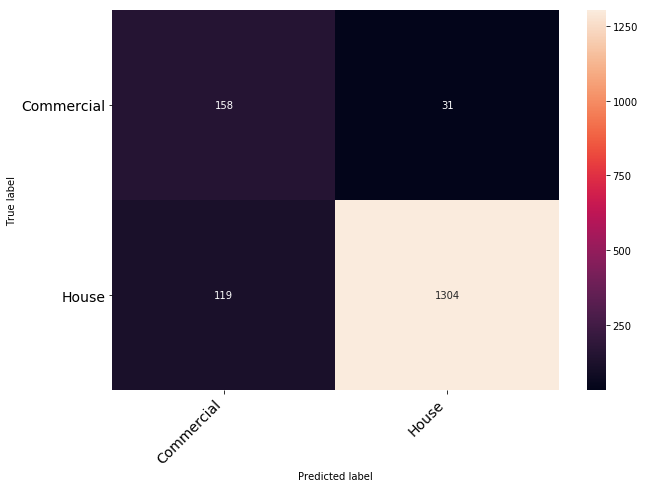

In [58]:
print_confusion_matrix(confArray2, class_labels)

The performance of the 2 models is roughly identical (it is marginally better with batch normalization, but barely).

# 4: Interpretability
### 4.1: Saliency Maps

In [19]:
#taken from the CNN Lab
class GradientSaliency(object):

    def __init__(self, model, output_index=0):
        input_tensors = [model.input,        # placeholder for input image tensor
                         #K.learning_phase(), # placeholder for mode (train or test) tense
                        ]
        gradients = model.optimizer.get_gradients(model.output[:,output_index], model.input)
        self.compute_gradients = K.function(inputs=input_tensors, outputs=gradients)

    def get_mask(self, input_image):
        
        x_value = np.expand_dims(input_image, axis=0)
        gradients = self.compute_gradients([x_value])[0]

        return gradients

In [20]:
#Taken from the CNN Lab
def saliency_visualization(data_generator, sample_size=5):
    image, labels = data_generator.next()
    
    plt.figure(figsize=(18, 10))
    reference = image[:sample_size]
    for i in range(reference.shape[0]):
        plt.subplot(int(reference.shape[0]/sample_size)+1, sample_size, i+1)
        plt.imshow(reference[i])
    plt.show()
    
    maps = []
    for i in range(sample_size):
        saliency = GradientSaliency(model2, np.argmax(label[i]))
        saliency_map = saliency.get_mask(image[i])
        saliency_map[saliency_map<0] = 0
        saliency_map = saliency_map / np.max(saliency_map)
        maps.append(saliency_map[0])
    saliency_maps = np.stack(maps)
    saliency_maps = np.max(saliency_maps, axis=3)
    plt.figure(figsize=(18, 10))
    reference = saliency_maps
    for i in range(reference.shape[0]):
        plt.subplot(int(reference.shape[0]/sample_size)+1, sample_size, i+1)
        plt.imshow(reference[i])
    plt.show()

In [82]:
#A slightly modified version from the CNN lab, only looks at a single image and layers the saliency map
#on the original image in the second for easier comparison
def saliency_visualization2(data_generator, sample_size=1):
    image, labels = data_generator.next()
    
    extent = (0, 64, 0 ,64)
    #fig = plt.figure(frameon=False)
    plt.figure(figsize=(18, 10))
    reference = image[:sample_size]
    for i in range(reference.shape[0]):
        #plt.subplot(int(reference.shape[0]/sample_size)+1, sample_size, i+1)
        plt.imshow(reference[i], cmap=plt.cm.gray, interpolation='nearest', extent = extent)
        plt.figure(figsize=(18, 10))
        plt.imshow(reference[i], cmap=plt.cm.gray, interpolation='nearest', extent = extent)
    #plt.show()
    
    maps = []
    for i in range(sample_size):
        saliency = GradientSaliency(model2, np.argmax(label[i]))
        saliency_map = saliency.get_mask(image[i])
        saliency_map[saliency_map<0] = 0
        saliency_map = saliency_map / np.max(saliency_map)
        maps.append(saliency_map[0])
    saliency_maps = np.stack(maps)
    saliency_maps = np.max(saliency_maps, axis=3)
    #plt.figure(figsize=(18, 10))
    reference = saliency_maps
    for i in range(reference.shape[0]):
        #plt.subplot(int(reference.shape[0]/sample_size)+1, sample_size, i+1)
        #smoothe = ndimage.gaussian_filter(reference[i], sigma=5) #[:,:,2]
        #plt.imshow(smoothe, alpha=0.2)
        plt.imshow(reference[i], alpha=.65, interpolation='bilinear', extent = extent)
    plt.show()

In [23]:
image, label = training_set.next()

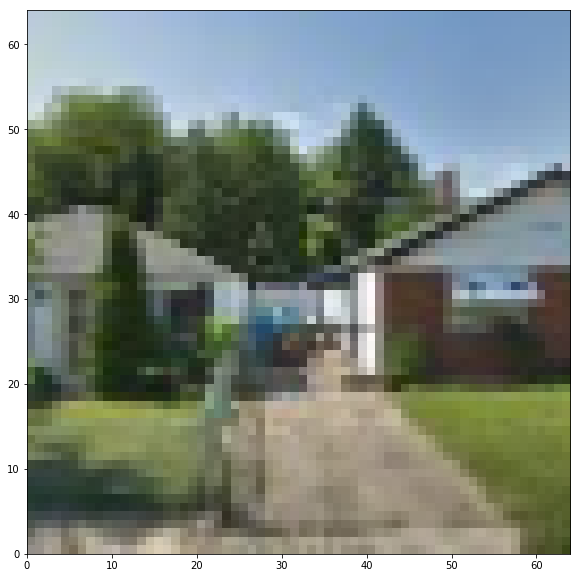

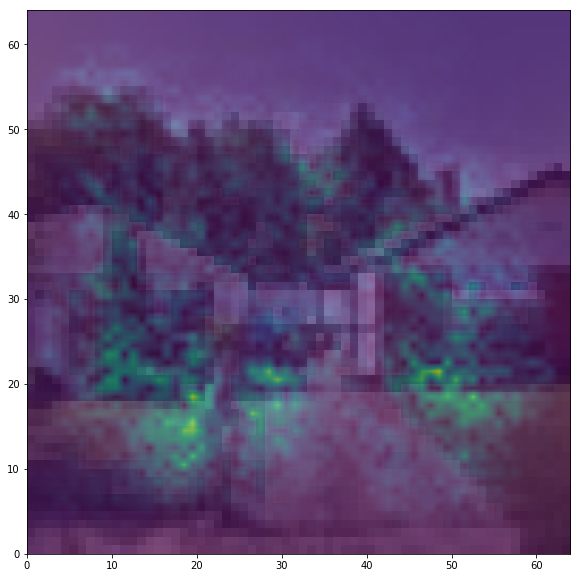

In [89]:
saliency_visualization2(training_set)

This image is interesting, as it appears that lawns and shrubs/door are the most "interesting" pieces of this image are the lawns and shrubs in front of the houses. It could be that the CNN has learned to recognize that shrubs and lawns in from of structures is an indication of a house instead of a commercial location.

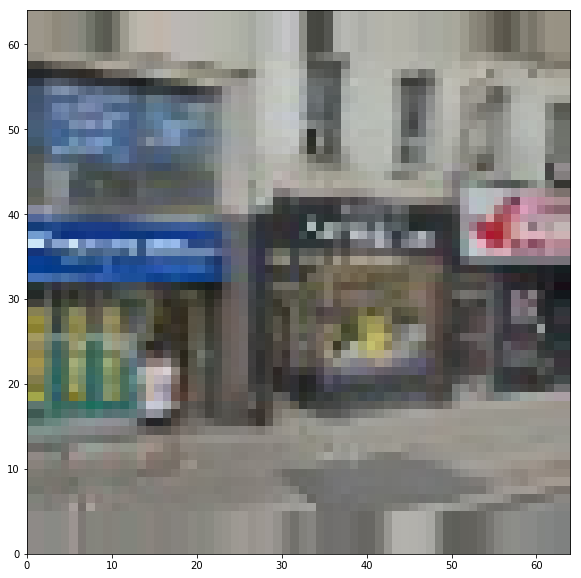

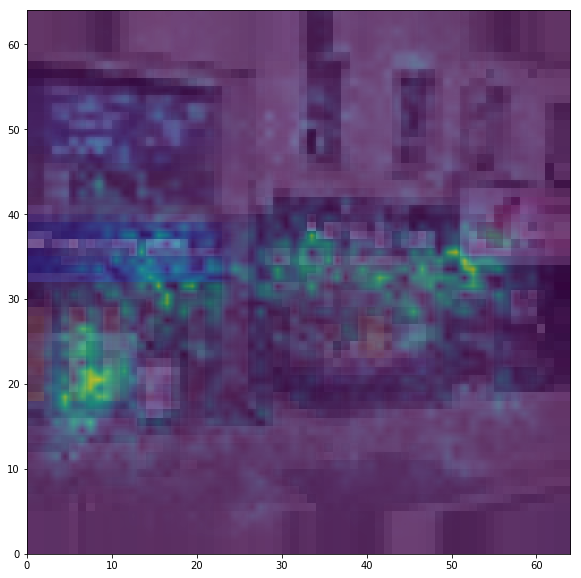

In [91]:
saliency_visualization2(training_set)

This saliency map is incredibly cool, as it somewhat validates my original hypothesis! I believed that signs would be a key way for the classifier to differentiate houses and commercial structures, which appears to be exactly what the classifier is picking up here.

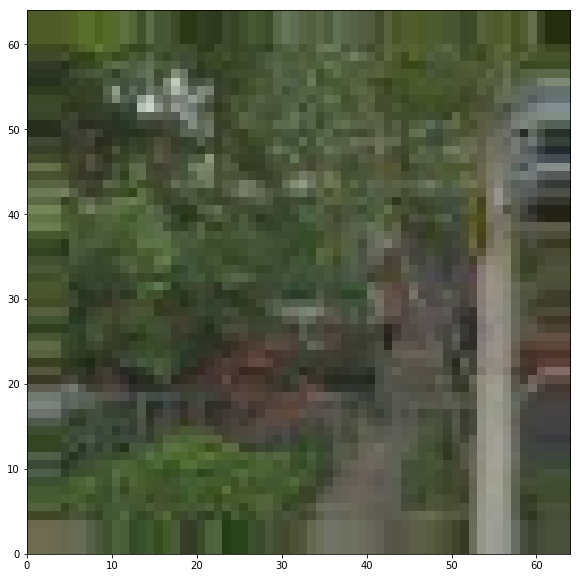

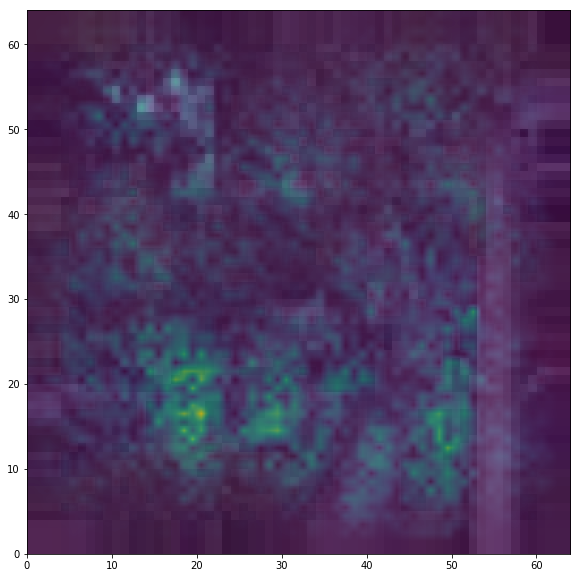

In [99]:
saliency_visualization2(training_set)

Another case where the shrubs in front of the house are what the classifer finds most interesting

# 5: Conclusion

Despite my initial concern around the size of the available dataset and the potentially noisy nature of the input, the classifer has been able to attain a meaningful level of performance at differentiating between homes and commercial locations based only on images scraped from google street view. 

The largest contributor to the success of the classifier was the implementation of an architecture that was specificly designed for binary-prediction, instead of using a general multiclass architecture. However, these increases could not have been obtained without using data augmentation, as training only on the original 1400 datapoints results in a classifier that exclusively guesses 'house'. 

The validation accuracy of 91.4% from the non-batch-normalized binary classifier could potentially be improved through a longer training time, along with a more complex CNN architecture. Expanding the task to classify all 6 classes, instead of this more limited 2-class problem, would likely require a 3-part solution to the issue of imbalanced classes:
1. More data would need to be gathered for some classes. There are fewer than 200 images tagged as 'industrial', which means that there is a high risk that the classifier would overfit to these specific examples, even with data augmentation
2. Data augmentation to increase the useable number of datapoints
3. Adjusting batch selection so that an equal balance of classes are represented in each batch. This could be used alongside class weights to ensure that the classifer does not become biased.

The saliency maps offer some insight into how the classifier functions. Lawns appear to be largerly influential in it's selection of 'house' as the typology, and signs appear to be highly influential for 'commercial'.